In [1]:
!nvidia-smi

Fri Dec 17 10:10:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    On   | 00000000:2B:00.0  On |                  N/A |
| 36%   63C    P2   255W / 340W |   3123MiB / 10009MiB |     74%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import yaml
import glob
import matplotlib.pyplot as plt
import os

from utils.plots import plot_results
from IPython.display import Image
from IPython.core.magic import register_line_cell_magic

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
%matplotlib inline

Setup complete. Using torch 1.8.1+cu111 _CudaDeviceProperties(name='GeForce RTX 3080', major=8, minor=6, total_memory=10009MB, multi_processor_count=68)


In [3]:
%cd chess_dataset/
!rm data.yaml
filename = "data.yaml"

with open(filename, "w") as f:
    f.write(f"train: {os.getcwd()}/train/images\n")
    f.write(f"val: {os.getcwd()}/valid/images\n")
    f.write("\n")
    f.write("nc: 12\n")
    f.write("names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']\n")
    f.close()
%cd ..

/home/rohan/object_detection/e2e_yolov5/chess_dataset
/home/rohan/object_detection/e2e_yolov5


In [4]:
%cat chess_dataset/data.yaml

train: /home/rohan/object_detection/e2e_yolov5/chess_dataset/train/images
val: /home/rohan/object_detection/e2e_yolov5/chess_dataset/valid/images

nc: 12
names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']


In [5]:
with open("chess_dataset/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

print(num_classes)

12


In [6]:
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [7]:
%cat models/custom_yolov5s.yaml


# parameters
nc: 12  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, 

In [8]:
!python train.py --img 416 --batch 8 --epochs 100 --data chess_dataset/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_chess_original  --cache

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=chess_dataset/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5s_chess_original, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2021-12-4 torch 1.8.1+cu111 CUDA:0 (GeForce RTX 3080, 10010MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, f

      5/99     1.02G   0.07768   0.06257   0.06232        15       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386     0.0526      0.627     0.0748      0.025

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      6/99     1.02G   0.07309   0.05999   0.06195         7       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386     0.0884      0.508      0.131     0.0444

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      7/99     1.02G   0.07116   0.06086   0.06163        27       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386     0.0552      0.531      0.123     0.0508

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      8/99     1.02G   0.06777   0.06


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     31/99     1.02G   0.05336   0.04027   0.04469         9       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.498      0.468      0.448      0.262

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     32/99     1.02G   0.05589   0.04784   0.04453        18       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.268      0.753      0.475       0.26

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     33/99     1.02G   0.05235   0.04951   0.04529        46       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386       0.23      0.822      0.479       0.28

     Epoch   gpu_mem       box      

               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.452      0.838       0.67      0.494

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     57/99     1.02G   0.03686    0.0355   0.03061        36       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.435      0.848      0.662       0.46

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     58/99     1.02G   0.03915   0.04001   0.03004        47       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.443      0.857      0.673      0.478

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     59/99     1.02G    0.0364   0.04088   0.02917        64       416: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     82/99     1.02G   0.02951   0.03166   0.02486        11       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.456       0.97      0.694      0.539

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     83/99     1.02G   0.02812   0.03206     0.024        19       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.459      0.966      0.689      0.539

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     84/99     1.02G   0.02781   0.03457   0.02384        58       416: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all         58        386      0.459      0.958      0.692      0.541

     Epoch   gpu_mem       box      

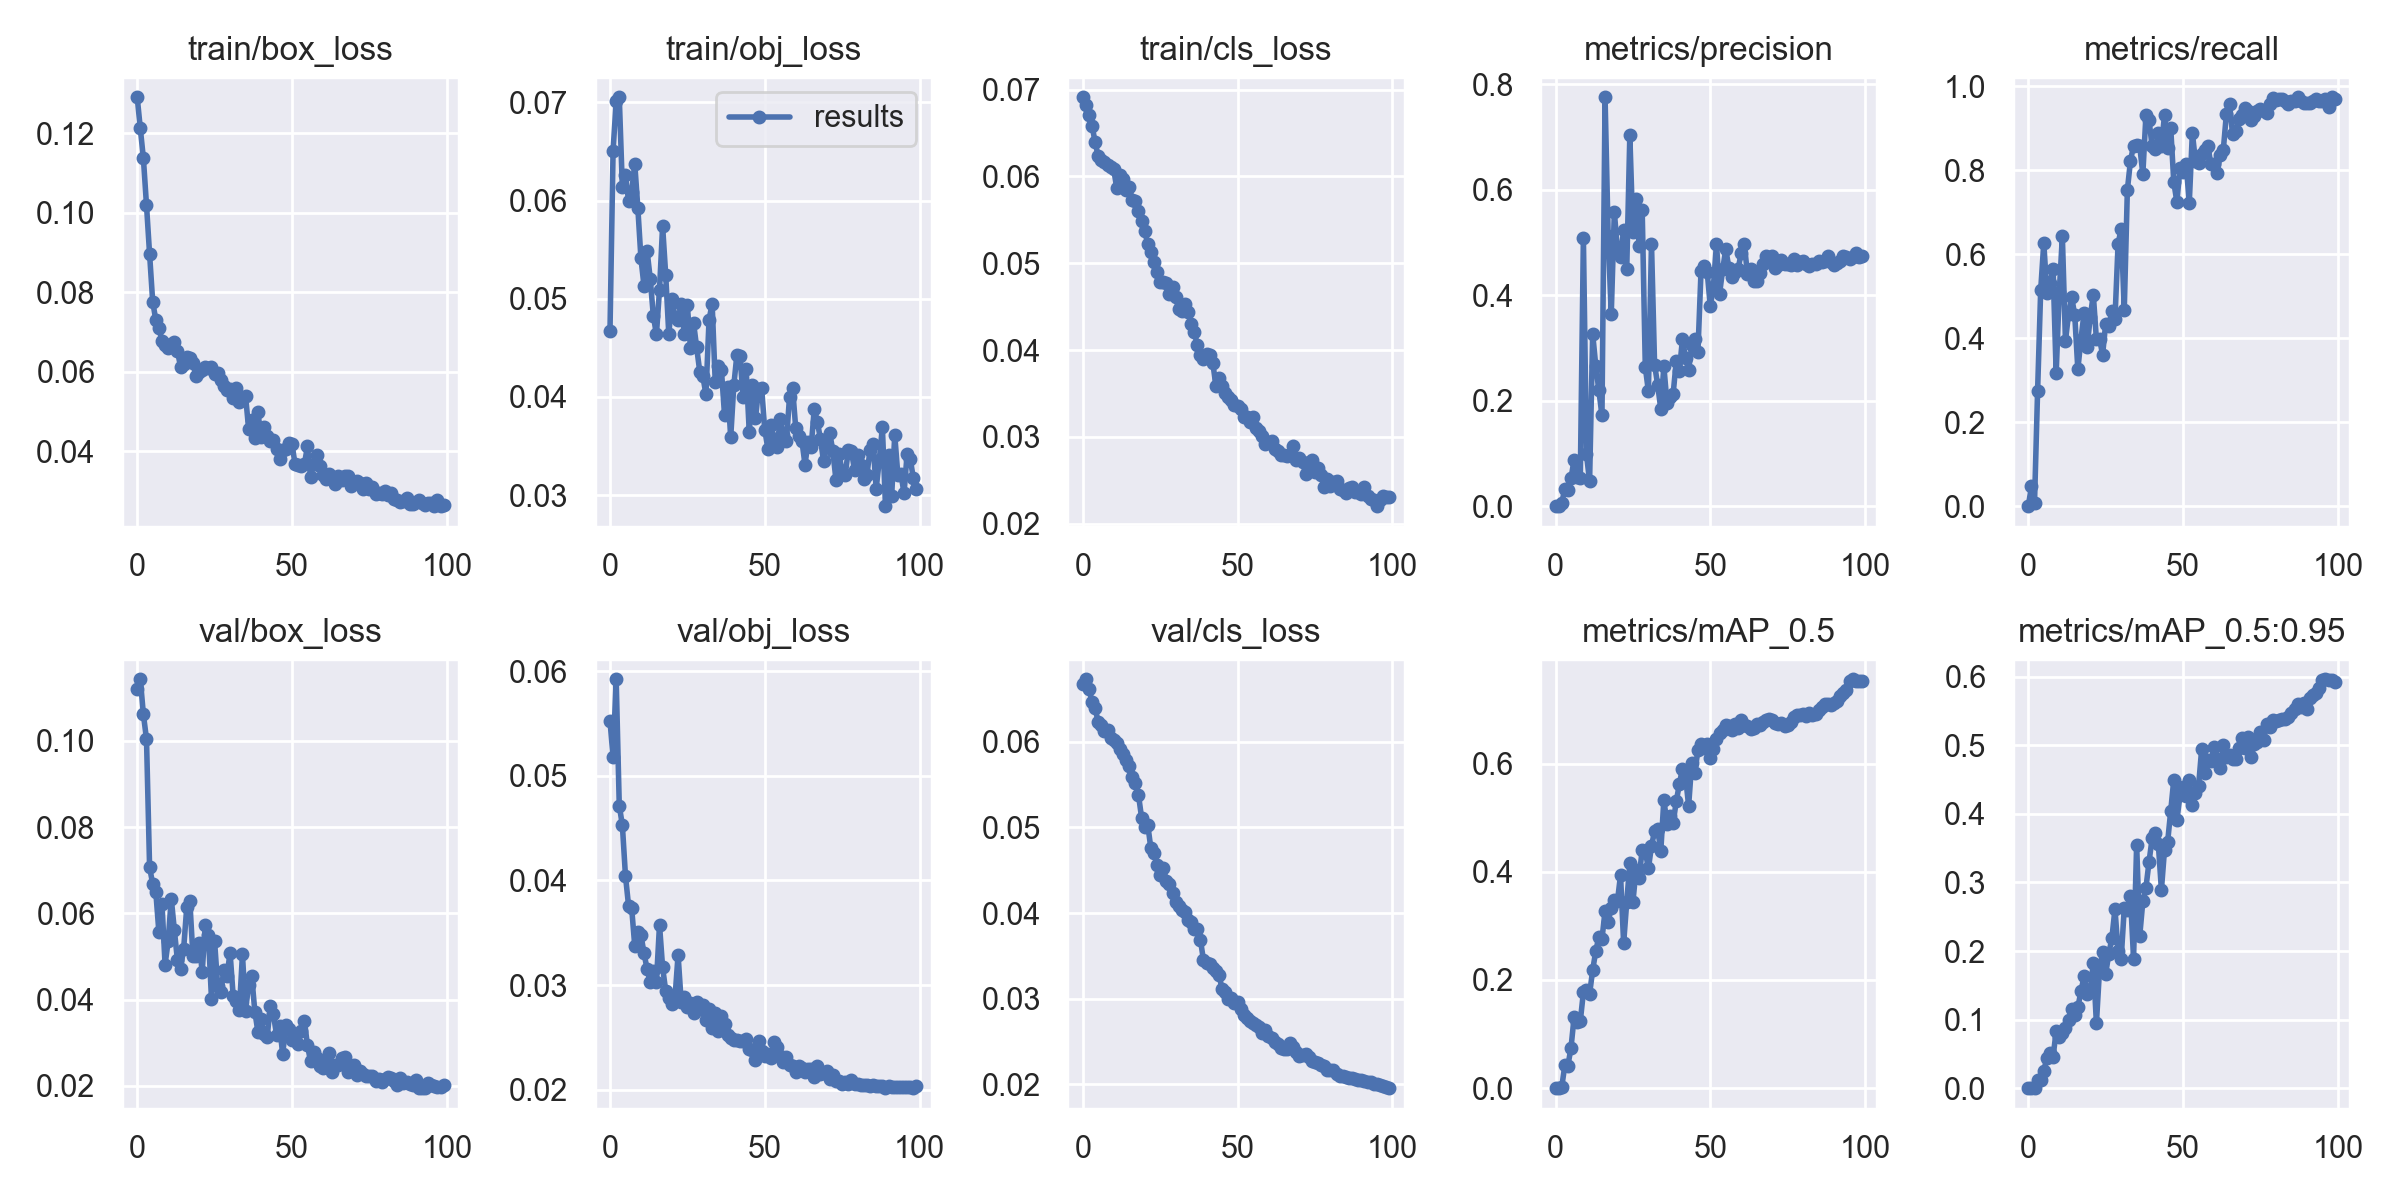

In [9]:
Image(filename = "/home/rohan/object_detection/e2e_yolov5/runs/train/yolov5s_chess_original/results.png")

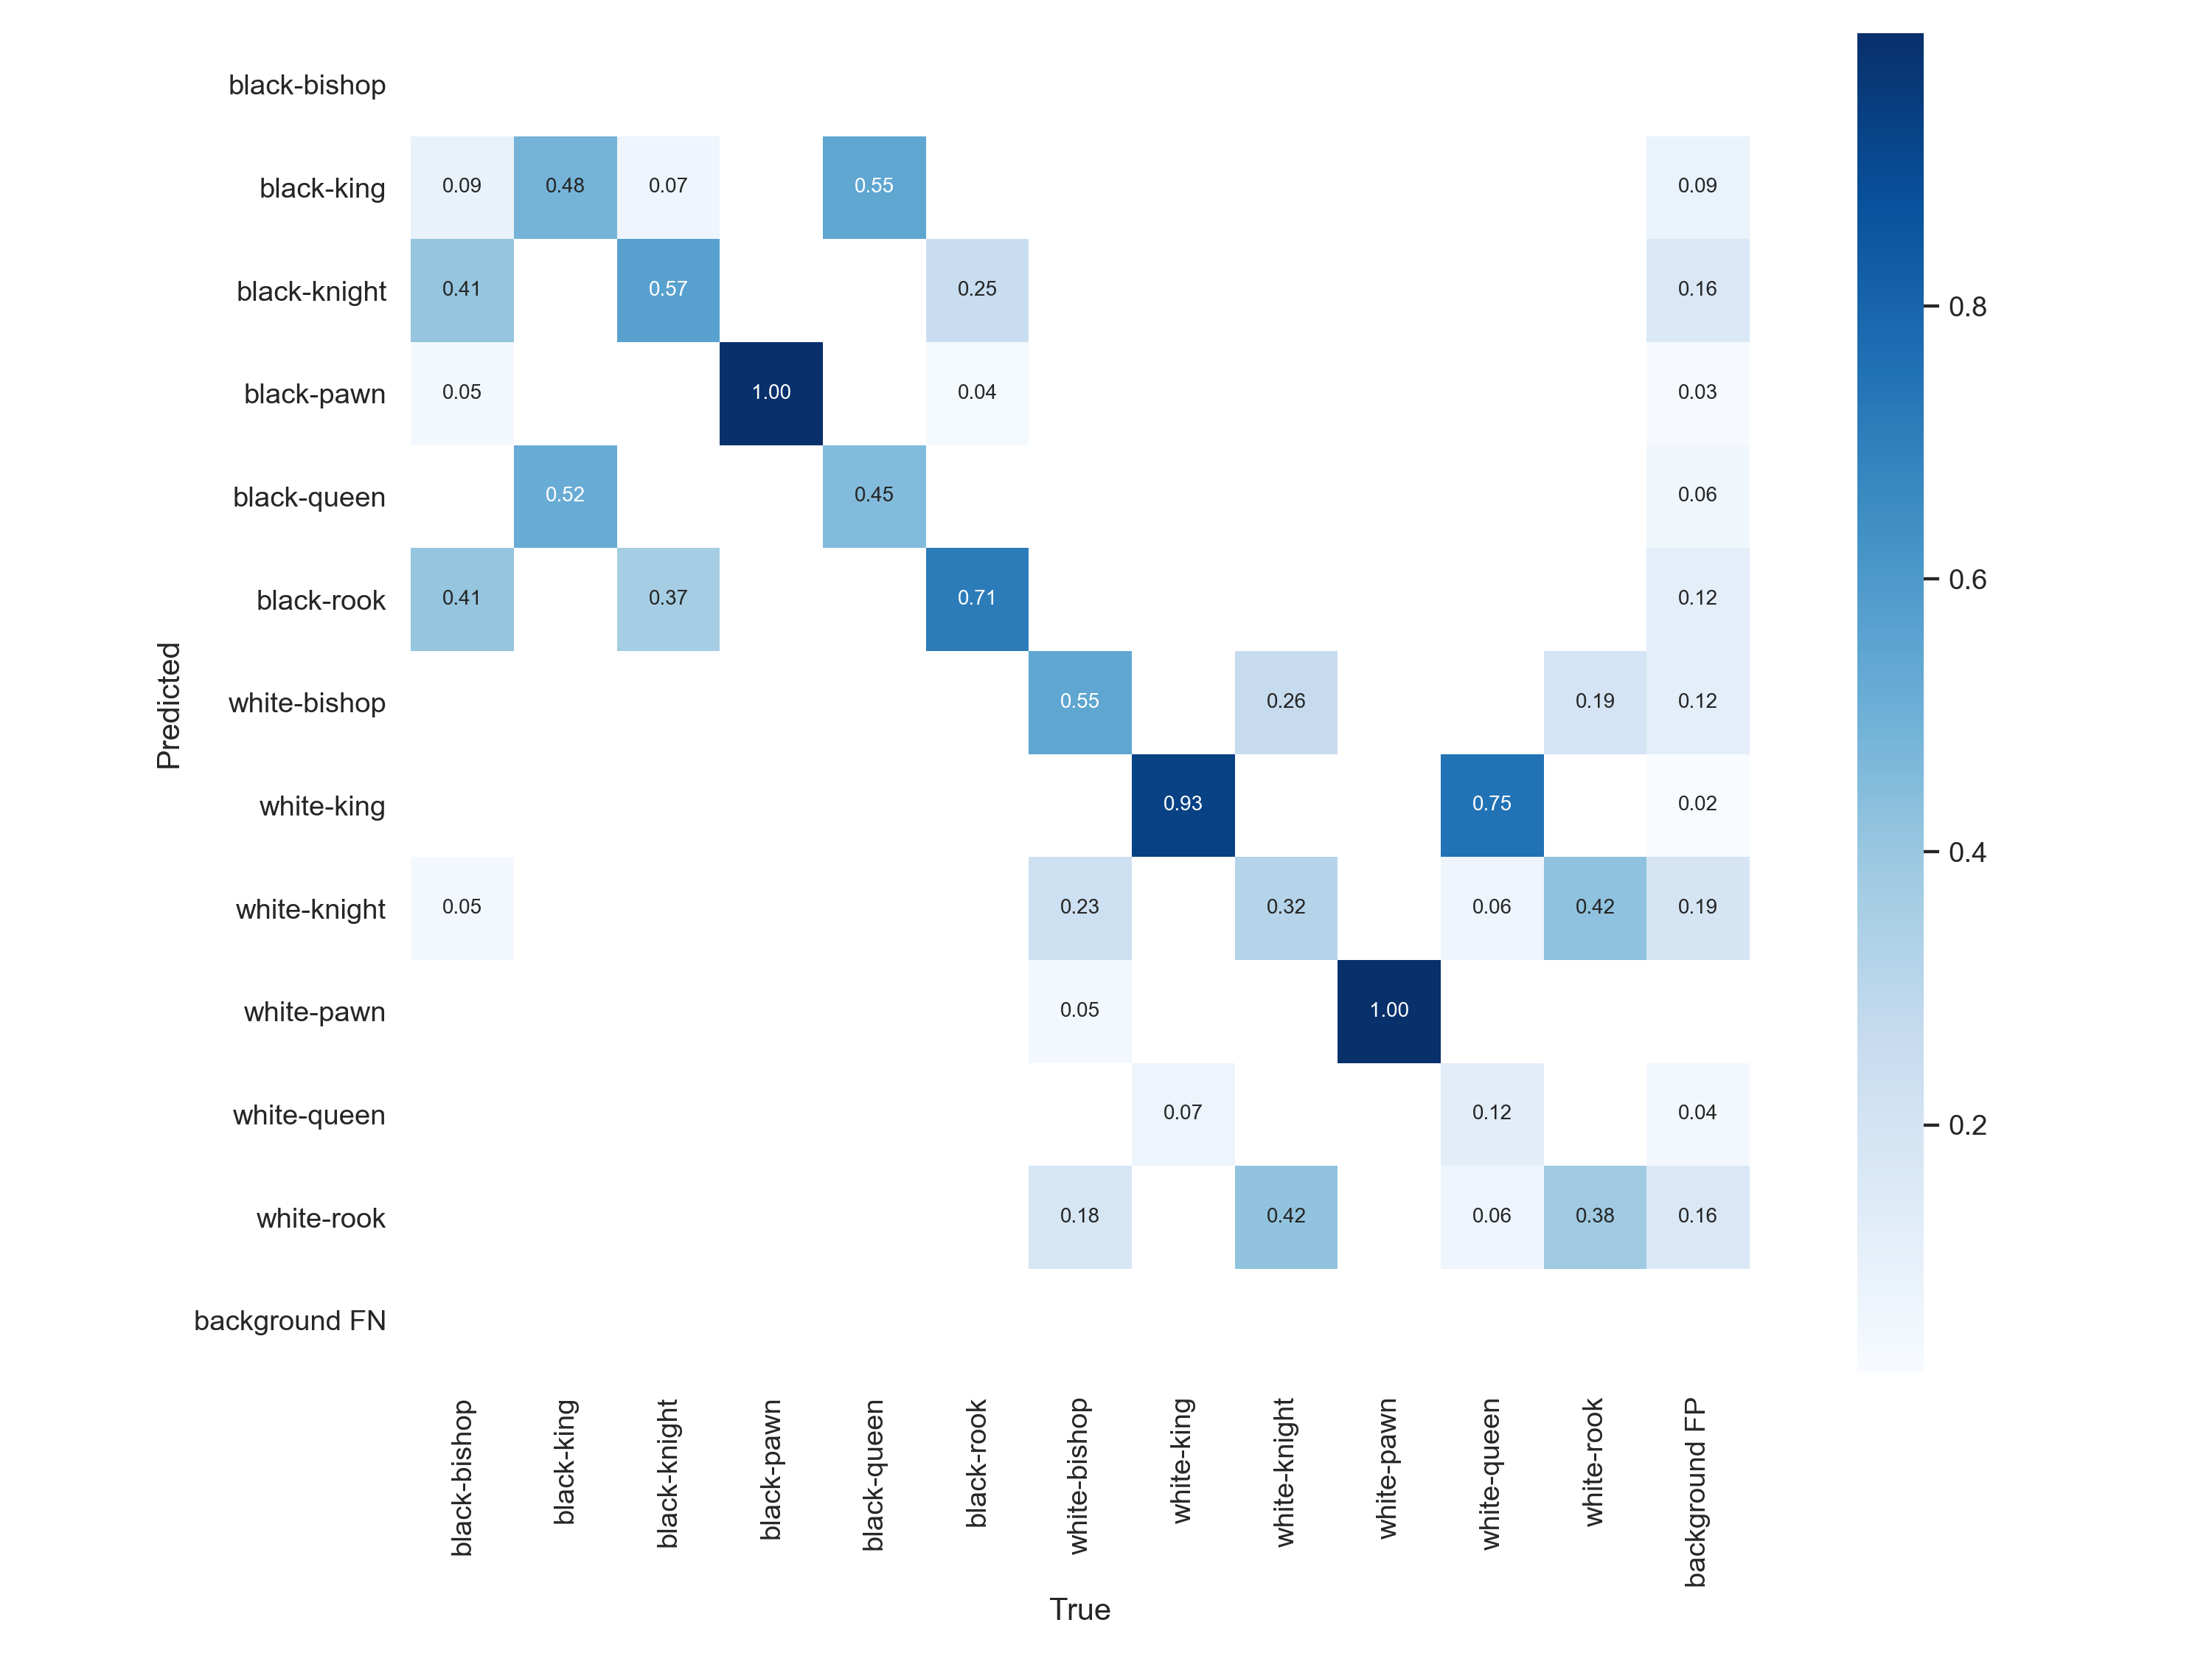

In [10]:
Image(filename = "/home/rohan/object_detection/e2e_yolov5/runs/train/yolov5s_chess_original/confusion_matrix.png")